# Exercise 7: Sinusoidal plus residual model

In this exercise you will analyze and synthesize sounds using the Harmonic plus Stochastic (HPS) model, `hpsModel.py`. There are two questions in this exercise. In the first one you will analyze a speech sound that we give and in the second one you will analyze a sound of your choice, in both cases using the HPS model. For each question, you will first describe some of the sound characteristics by listening to the sounds and visualizing their spectrogram, characteristics that should be of relevance for the analysis/synthesis with the HPS model. Then from the described characteristics you will set the appropriate values for the different analysis parameters, explaining the choices you make, and analyze and synthesize the sounds with the HPS model software.

For this exercise, you can use `models_GUI.py`, to experiment with the parameters easily and then use them in here. Feel free to modify the code of the model if needed and add it also here. 

To help you with the exercise, we first give a brief description of the analysis parameters used by the HPS model function:

1. Window type (`window`) and Window size (`M`): The choice of window size and window type has a time-frequency trade-off. Choosing a longer window helps resolve sinusoidal components that are close in frequency, but gives a poorer temporal resolution. Shorter windows track transients better, maintaining sharp onsets, but may not resolve frequency components so well. For monophonic harmonic sounds, the window size is best chosen based on the lowest value of f0 and the fastest change in pitch.
2. FFT size (`N`): The FFT size is chosen as a power of 2 larger than the window size M. A large FFT size N, compared with M, results on an interpolated DFT spectrum and leads to better estimation of spectral peak values. However, given that the software also uses parabolic interpolation we can achieve good peak estimates with not too big FFT sizes, for example just the next power of 2 larger than M.
3. Threshold in negative dB (`t`): The peak picking threshold is the lowest amplitude peak that will be identified. Setting a very low threshold ($<-120$dB) will take most peaks, but the threshold should be set as high as possible to minimize the presence of peaks that do not correspond to sinusoidal peaks (the window main-lobe).
4. Maximum number of harmonics (`nH`): The maximum number of harmonics that can be detected in a harmonic sound is influenced by the brightness of the sound, but also by the sampling rate and by how low is the f0. The recording quality can also have an impact. For a compact representation, we should only capture the relevant harmonics, the ones that affect the perceptual quality of the reconstruction.
5. Minimum f0 frequency in Hz (`minf0`) and Maximum f0 frequency in Hz (`maxf0`): The `minf0` and `maxf0` are the parameters used by the fundamental frequency detection algorithm to obtain possible `f0` candidates to be passed to the TWM algorithm. Choosing a correct range of `f0`, but the smallest possible, greatly improves the `f0` estimation by TWM algorithm, specially minimizing octave errors, which are very common in `f0` detection algorithms. You should select the values by first looking at the spectrogram of the sound and identifying the lowest and highest fundamental frequencies present.
6.  Threshold in the f0 detection (`f0et`): This is the maximum error allowed in the TWM algorithm. If the value is too large, the algorithm might detect fundamental frequencies that might not be actually so. Instead, if is it too small, good fundamental frequencies might not be detected, returning value 0 at that frame. The smaller the value the more restrictive the algorithm behaves. A normal strategy is to start with a big value ($> 10$) and then making it smaller until we only keep what we consider to be the relevant f0 components, discarding the \texttt{f0} values in the parts of the sound that do not have a clear harmonic structure.
7. Slope of harmonic deviation (`harmDevSlope`): Slope of the harmonic deviation allowed in the estimated harmonic frequencies, compared to a perfect harmonic frequencies. If the value is 0 it means that we allow the same deviation for all harmonics, which is hard coded to \texttt{f0}$/3$. A value bigger than 0 means that higher harmonics will be allowed to deviate more than the lower harmonics from perfect harmonicity (which is a common behaviour). It normally works better to have a value slightly bigger than 0, for example around 0.01.
8. Minimum length of harmonics (`minSineDur`): Any harmonic track shorter, in seconds, than minSineDur will be removed. This is a good parameter for discarding harmonic tracks that are too short and thus that do not correspond to stable harmonics of the sound. Typically we put a value bigger that 0.02 seconds.
9. Decimation factor of magnitude spectrum for stochastic analysis (`stocf`): The stochastic approximation of the residual is a decimated version of the magnitude spectrum of the residual. This leads to a compact and smooth function that approximates the magnitude spectrum of the residual at each frame. The smaller the stocf, higher the decimation will be and thus will result in a more compact representation. A value of 1 means no decimation, leaving the residual magnitude spectrum as it is. A value of 0.2 (a good starting value) will decimate the original residual magnitude spectrum by a factor of 1/5.

The most compact and useful representation of a sound, least number of analysis data values while maintaining the sound quality in the synthesis, will be obtained by using a high t, a small `nH`, a small decimation factor for stochastic analysis, stocf, and by succeeding in detecting only the harmonics they are perceptually relevant. The values of `nH`, `minf0` and `maxf0` should be chosen by first visualizing the spectrogram of the sound with a large enough window size. There is usually a range of all parameter values for which we get a good reconstruction. Also the analysis parameters are not independent of each other and hence they need to be considered together. For testing if the detection of the harmonics have been done correctly (and for improving it) it is very useful to perform the Harmonic plus Residual analysis/synthesis (HPR model) using the same parameters and listen to the residual component for possible artifacts resulting from the harmonic analysis.

## Part 1. Obtain a good harmonic+stochastic analysis of a speech sound

Analyze and synthesize the `sound speech-female.wav`, available from the sounds directory, using `hpsModelAnal()` and `hpsModelSynth()` from the `hpsModel.py` module. The goal is to obtain the best possible reconstruction using the most compact representation. Perform the following two tasks:

1. Analyze the sound with the STFT using `models-GUI.py`, or with any other analysis tool you might wish, and describe the characteristics of the sound that might be relevant to perform the HPS analysis. Specially important characteristics for the analysis include pitch range and maximum number of harmonics. Explain the sound: write no more than a paragraph for this description.
2. Select the analysis parameters that give a good reconstruction and at the same time result in the most compact representation possible, specially related to the number of harmonics and the number of stochastic coefficients. We recommend that you first perform the harmonic plus residual analysis and by listening to the residual make some decisions on the best parameters to use. You can listen to the output sounds (harmonic, residual, stochastic components) and fine tune the parameters. Save the output sounds. Explain the choices for the following parameters: window type, window size, FFT size, minimum f0, _maximum f0, error threshold in f0 detection, number of harmonics, and stochastic decimation factor. Explain the analysis: in your descriptions do not use more than one sentence per parameter.

__Example:__ example of an analysis/synthesis for a male speech sound:

1. Input sound: http://freesound.org/people/xserra/sounds/317744/
2. Harmonic component: http://freesound.org/people/xserra/sounds/327139/
3. Residual component: http://freesound.org/people/xserra/sounds/327141/
4. Stochastic component: http://freesound.org/people/xserra/sounds/327137/
5. Harmonic+stochastic resynthesis: http://freesound.org/people/xserra/sounds/327140/


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import get_window
import sys, os
sys.path.append('../software/models/')
import utilFunctions as UF
import stft as STFT
import hpsModel as HPS
import IPython.display as ipd

<ipython-input-2-1150cbaa930c>:34: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(frmTime, binFreq, np.transpose(mX[:,:int(N*maxplotfreq/fs+1)]))


'\nSound description: first, from listening to the sound, I was able to identify the parts of the speech which \ncorrespond to the lowest and highest frequencies. In particular, the highest frequency seems to be located at the end \nof the word "altre" just before the first pause of the poem, and the lowest seems to be located at the word "tel", \njust before the second pause. Using the STFT, I could identify the specific values of these lowest and highest \nfrequencies. Because we need to be able to distinguish easily the different frequency components, the window size was \nset to a relatively high value, 3501, and the FFT size to the next power of 2, that is, 4096. The window type was set \nto "blackman". With this configuration, the individual harmonics were well defined, and zooming in to the lowest \nfrequencies, I could see that the lowest fundamental corresponds to a value around 140 Hz, whereas the highest \nfundamental is around 260 Hz. In addition, because this is a speech s

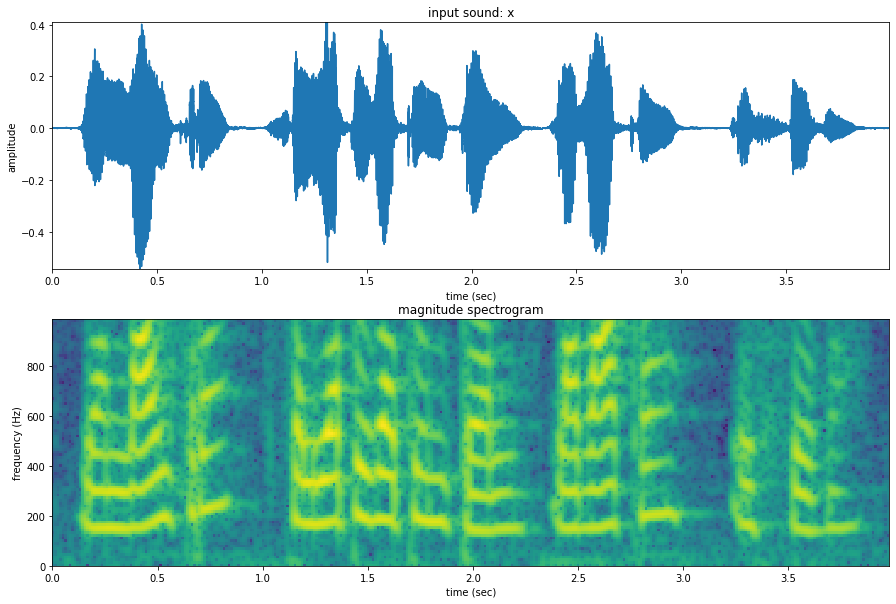

In [2]:
# E7 - 1.1: Set STFT analysis parameters and visualize spectrogram of speech-female.wav sound

input_file = '../sounds/speech-female.wav'

### set parameters
window = 'blackman'
M = 3501
N = 4096
H = 512

# no need to modify anything after this
fs, x = UF.wavread(input_file)
w = get_window(window, M, fftbins=True)
mX, pX = STFT.stftAnal(x, w, N, H)

ipd.display(ipd.Audio(data=x, rate=fs))

plt.figure(figsize=(15, 10))
maxplotfreq = 1000.0

# plot input sound
plt.subplot(2,1,1)
plt.plot(np.arange(x.size)/float(fs), x)
plt.axis([0, x.size/float(fs), min(x), max(x)])
plt.ylabel('amplitude')
plt.xlabel('time (sec)')
plt.title('input sound: x')

# plot magnitude spectrogram
plt.subplot(2,1,2)
numFrames = int(mX[:,0].size)
frmTime = H*np.arange(numFrames)/float(fs)
binFreq = fs*np.arange(N*maxplotfreq/fs)/N
plt.pcolormesh(frmTime, binFreq, np.transpose(mX[:,:int(N*maxplotfreq/fs+1)]))
plt.xlabel('time (sec)')
plt.ylabel('frequency (Hz)')
plt.title('magnitude spectrogram')

'''
Sound description: first, from listening to the sound, I was able to identify the parts of the speech which 
correspond to the lowest and highest frequencies. In particular, the highest frequency seems to be located at the end 
of the word "altre" just before the first pause of the poem, and the lowest seems to be located at the word "tel", 
just before the second pause. Using the STFT, I could identify the specific values of these lowest and highest 
frequencies. Because we need to be able to distinguish easily the different frequency components, the window size was 
set to a relatively high value, 3501, and the FFT size to the next power of 2, that is, 4096. The window type was set 
to "blackman". With this configuration, the individual harmonics were well defined, and zooming in to the lowest 
frequencies, I could see that the lowest fundamental corresponds to a value around 140 Hz, whereas the highest 
fundamental is around 260 Hz. In addition, because this is a speech sound, the harmonics are quite abundant, and the 
presence of vowels can be clearly seen as they have very rich harmonics. As an initial value for the maximum number 
of harmonics to be analysed in the next section, we can start with a fairly high value of 100, and then try to 
decrease it until some important perceptual differences are noticed when synthesizing the sound. In regards to the 
stochastic part of the sound, when listening to the sound I could clearly notice the breathing aspect of it, specially
during the consonants, like in the "tr" sound of the word "altre", or the noticeable breathing resultant from the "c"
sound of "vaca". Looking at the spectrogram I could see, for instance, that around the location of the "altre" word, 
the harmonics become more unstable and they are much less clear in the transition of the two vowels, which 
corresponds to the "tr" sound. In general, I could see that for the consonants, the harmonics tend to disappear as 
well as in the pauses between the different segments of the poem. 
'''

In [3]:
# E7 - 1.2: Perform Harmonic plus Stochastic analysis and synthesis of speech-female.wav sound

input_file = '../sounds/speech-female.wav'

### fill the parameters
window ='blackman'
M = 1891
N = 2048
t = -80
minSineDur = 0.07
nH = 80 
minf0 = 100
maxf0 = 300
f0et = 5
harmDevSlope = 0.02
stocf = 0.3

# no need to modify anything after this
Ns = 512
H = 128

(fs, x) = UF.wavread(input_file)
w = get_window(window, M, fftbins=True)
hfreq, hmag, hphase, stocEnv = HPS.hpsModelAnal(x, fs, w, N, H, t, nH, minf0, maxf0, f0et, harmDevSlope, minSineDur, Ns, stocf)
y, yh, yst = HPS.hpsModelSynth(hfreq, hmag, hphase, stocEnv, Ns, H, fs)

ipd.display(ipd.Audio(data=x, rate=fs))
ipd.display(ipd.Audio(data=y, rate=fs))

In [ ]:
# E7 - 1.3: Explain the HPS analysis parameters used
'''
The window type was set to "blackman", since this type of window has very low sides lobes and we want to minimize 
the presence of spurious peaks. The window size was now a lower value than when computing the STFT, the reason is that 
for the STFT we needed high frequency resolution to identify the fundamental frequencies, but now we also care about 
the time resolution, so the window size was computed using the lowest fundamental frequency from the previous section, 
the main lobe size of the "blackman" window and the sampling rate (6*44100/140.0 = 1890) and making sure it was an 
odd size, in this case, 1891 was selected. The FFT size was the next power of 2 greater than the window size, that 
is, 2048. The peak detection threshold (t) was set to -80, since this value is appropriate to avoid the presence of 
peaks that do not correspond to sinusoidal peaks while capturing the relevant sinusoidal peaks. The number of harmonics 
was first set to 100, then decreased until 40, which is a fair value which does not compromise in a significant way 
the perceptual characteristics of the sound (it captures all the harmonics up to 5000 Hz, which is the range for most 
frequencies important for humans in regards to speech). The minimum and maximum f0 were set to 100 and 300, 
respectively, taking into account the range covered by the lowest and highest fundamental frequencies identified in 
the previous section (140 and 260 Hz). The error threshold in the f0 detection (f0et) was set to 5, as a rather small 
value that is appropriate to keep the relevant f0 components. Finally, the stochastic decimation factor was set to 
0.3, as the lowest value that produced the more similar synthetized sound to the original one. The stochastic sound 
using this value for the decimation factor sounds like a whisper and the words can be understood, a lower value of 
this decimation factor would produce a more noisy type of sound in which the words are not totally understood, which 
is undesirable for this case, since the breathing component of the original sound should maintain this type of whiper 
quality. However, in the synthesized sound, the whipering is more noticeable than in the original sound. The 
stochastic modeling of the noise component definetely enhances in some way this part when integrated with the 
harmonic component, so the resultant synthesized sound sounds a bit more noisy (limitation of HpS model).
'''

## Part 2. Obtain a good harmonic+stochastic analysis of a monophonic musical phrase

Analyze and synthesize a harmonic sound of your choice from Freesound using the harmonic plus stochastic model. The goal is to obtain the best possible reconstruction using the most compact representation possible. Return an explanation of what you have done and why, together with the re-synthesized sounds.

The sound from freesound to use could be in any format, but to use the sms-tools software you will have to first convert it to be a monophonic file (one channel), sampling rate of 44100, and 16bits samples. You might also have to select a fragment of the sound.

_Part 2.1:_ Choose a sound from freesound to be analyzed, download it, and if necessary, edit it, and covert it to the right format. It should be a short monophonic musical fragment of a harmonic sound, not longer than 5 seconds. In the explanation add the freesound link of the sound selected and write a brief explanation of why you chose this sound.

_Part 2.2:_ Analyze the chosen sound with the STFT, or with any other analysis or tool you might wish, and describe the characteristics of the sound that will be relevant to perform the harmonic plus stochastic analysis. Important characteristics for the analysis include the pitch range and the maximum number of harmonics. Write no more than a paragraph.

_Part 2.3:_ Select the analysis parameters that give a good reconstruction and at the same time result in to the most compact representation, specially related to the number of harmonic and the number of stochastic coefficients. We recommend that you first perform the harmonic plus residual analysis and by listening to the residual make some decisions on the best parameters to use. You can listen to the output sounds (harmonic, residual, stochastic components) and fine tune the parameters. Save the output sounds. Explain the choices for the following parameters: window type, window size, FFT size, minimum f0, maximum f0, error threshold in f0 detection, number of harmonics, and stochastic decimation factor. In your descriptions do not use more than one sentence per parameter.

In [4]:
# E7 - 2.1: download a sound from freesound, read it with waveread, and describe it

#### your code here
input_file = '../sounds/bassoon.wav'
(fs, x) = UF.wavread(input_file)
ipd.display(ipd.Audio(data=x, rate=fs))

### write a brief description of the sound
"""
Link to the sound in Freesound: https://freesound.org/people/elettroedo/sounds/255173/
I selected a short bassoon phrase. The reason why I selected it is because this sound has a clear harmonic component 
(the melody) and also a stochastic component (the breathing aspect and the sound of the key pulsations of the 
instrument), so this makes it very suitable to be analyzed with the HpS model. In addition, the sound clip is 
already a monophonic sound file, with sampling rate of 44100 Hz and 16 bits sample, and the phrase was already short 
enough (belof 5 seconds) for the purpose of this exercise, so I did not need to do any rearrangements. I downloaded 
the sound, rename it to "bassoon.wav" and placed it on the "sounds" folder.
"""

'\nLink to the sound in Freesound: https://freesound.org/people/elettroedo/sounds/255173/\nI selected a short bassoon phrase. The reason why I selected it is because this sound has a clear harmonic component \n(the melody) and also a stochastic component (the breathing aspect and the sound of the key pulsations of the \ninstrument), so this makes it very suitable to be analyzed with the HpS model. In addition, the sound clip is \nalready a monophonic sound file, with sampling rate of 44100 Hz and 16 bits sample, and the phrase was already short \nenough (belof 5 seconds) for the purpose of this exercise, so I did not need to do any rearrangements. I downloaded \nthe sound, rename it to "bassoon.wav" and placed it on the "sounds" folder.\n'

<ipython-input-5-2a3ef3b28a57>:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(frmTime, binFreq, np.transpose(mX[:,:int(N*maxplotfreq/fs+1)]))


'\nSound description: first, from listening to the sound, I was able to identify the parts of the phrase which correspond \nto the lowest and higuest frequencies. In particular, the highest frequency seems to be located at the fourth note \n(the one that is in the middle of the phrase and is longer), and the lowest frequency corresponds to the first and \nlast notes of the phrase. Using the STFT, I could identify the specific values of these lowest and highest \nfrequencies. As in the previous exercise, because we need to identify the frequency components, the window size was \nset to a relatively high value of 3501, and the FFT size as the next power of 2, 4096. The window type was set to \n"blackman". With these settings, the individual harmonics could be clearly seen, and zooming in to the lowest part \nof the spectrum I could see that the lowest fundamental corresponds to a value around 146 Hz and the highest fundamental \nis around 226 Hz. For this particular sound, I could see th

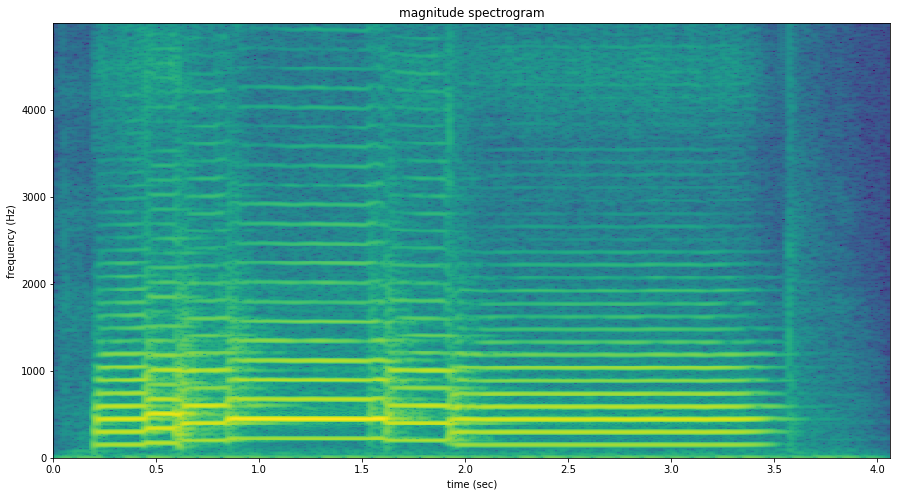

In [5]:
# E7 - 2.2: Set STFT analysis parameters and visualize spectrogram of chosen sound. Explain relevant sound 
# characteristics for HPS model

### basic visualization and listening of sound
input_file = '../sounds/bassoon.wav'
window = 'blackman'
M = 3501
N = 4096
H = 512

# no need to modify anything after here
fs, x = UF.wavread(input_file)
w = get_window(window, M, fftbins=True)
mX, pX = STFT.stftAnal(x, w, N, H)

ipd.display(ipd.Audio(data=x, rate=fs))

plt.figure(figsize=(15, 8))
maxplotfreq = 5000.0
numFrames = int(mX[:,0].size)
frmTime = H*np.arange(numFrames)/float(fs)
binFreq = fs*np.arange(N*maxplotfreq/fs)/N
plt.pcolormesh(frmTime, binFreq, np.transpose(mX[:,:int(N*maxplotfreq/fs+1)]))
plt.xlabel('time (sec)')
plt.ylabel('frequency (Hz)')
plt.title('magnitude spectrogram')

### describe the characteristics relevant to perform the harmonic plus stochastic analysis
"""
Sound description: first, from listening to the sound, I was able to identify the parts of the phrase which correspond 
to the lowest and higuest frequencies. In particular, the highest frequency seems to be located at the fourth note 
(the one that is in the middle of the phrase and is longer), and the lowest frequency corresponds to the first and 
last notes of the phrase. Using the STFT, I could identify the specific values of these lowest and highest 
frequencies. As in the previous exercise, because we need to identify the frequency components, the window size was 
set to a relatively high value of 3501, and the FFT size as the next power of 2, 4096. The window type was set to 
"blackman". With these settings, the individual harmonics could be clearly seen, and zooming in to the lowest part 
of the spectrum I could see that the lowest fundamental corresponds to a value around 146 Hz and the highest fundamental 
is around 226 Hz. For this particular sound, I could see that the highest harmonics have much less energy than the 
lowest ones and, for the last maintained note I could appreciate that for harmonics higher than approximately 4000 Hz 
there were some noisy components in between and there was some more unstability. This suggests that there is some 
significant noisy component in that frequency range (very likely the breathing part) that should be analyzed with 
the stochastic model. Also, the unstability is clearly seen in the note transitions, this could be due to the noise 
of the key pulsations. As an initial value for the maximum number of harmonics to be analysed in the next section, 
we can start with a relatively high value of 80, and then try to decrease it as long as there are not important 
perceptual differences on the synthesized sound. 
"""


In [6]:
# E7 - 2.3: Perform Harmonic plus Stochastic analysis and synthesis of chosen sound


### fill the parameters
input_file = '../sounds/bassoon.wav'
window = 'blackman'
M = 1813
N = 2048
t = -80
minSineDur = 0.07
nH = 40 
minf0 = 100
maxf0 = 300
f0et = 5
harmDevSlope = 0.02
stocf = 0.2

# No need to modify
Ns = 512
H = 128

(fs, x) = UF.wavread(input_file)
w = get_window(window, M, fftbins=True)
hfreq, hmag, hphase, stocEnv = HPS.hpsModelAnal(x, fs, w, N, H, t, nH, minf0, maxf0, f0et, harmDevSlope, minSineDur, Ns, stocf)
y, yh, yst = HPS.hpsModelSynth(hfreq, hmag, hphase, stocEnv, Ns, H, fs)

ipd.display(ipd.Audio(data=x, rate=fs))
ipd.display(ipd.Audio(data=y, rate=fs))

In [ ]:
# E7 - 2.4: Explain the choices of HPS analysis parameters
'''
The window type was set to "blackman", since this type of window has very low sides lobes and we want to minimize 
the presence of spurious peaks. The window size was, as in the previous exercise, now a lower value than when 
computing the STFT for the same sound, the reason behind being that for the STFT we needed high frequency resolution 
to identify the fundamental frequencies, but now we also care about the time resolution, so the window size was 
computed as 6*44100/146.0 = 1812, and making sure it was an odd size, in this case, 1813 was selected. The FFT size 
was the next power of 2 greater than the window size, that is, 2048. The peak detection threshold (t) was set to -80,
since this value is appropriate to avoid the presence of peaks that do not correspond to sinusoidal peaks while 
capturing the relevant sinusoidal peaks. The number of harmonics was first set to 80, then decreased until 40, which 
is a fair value which does not compromise in a significant way the perceptual characteristics of the sound (we saw 
that the high frequency harmonics have much more energy than the lower ones, and 40 harmonics is enough to cover the 
range up to 5000 Hz). The minimum and maximum f0 were set to 100 and 300, respectively, taking into account the range
covered by the lowest and highest fundamental frequencies identified in the previous section (146 and 226 Hz). The 
error threshold in the f0 detection (f0et) was set to 5, as a rather small value that is appropriate to keep the 
relevant f0 components. Finally, the stochastic decimation factor was set to 0.2, as the lowest value that produced 
the more similar synthetized sound to the original one. The stochastic sound using this value for the decimation 
factor collects the breathing aspects as well as the noise of the keys being pressed for each of the notes of the 
melody. In the synthesized sound, this key pressing aspect is more noticeable than in the original sound. The 
stochastic modeling of the noise component definetely enhances in some way this part when integrated with the 
harmonic component, so the resultant synthesized sound sounds a bit more noisy (limitation of HpS model).
'''